## Inversion for a coupled acoustic-gravity system

Before running `pip install tinyda ray' 

### Problem setup

Let $\varphi$ be the potential for the flow velocity, it is solution to 
\begin{align}\label{eq:forwardmodel}
    \frac{\partial^2 \varphi}{\partial t^2}
    - c^2 \Delta \varphi 
    + g \frac{\partial \varphi}{\partial z}
    = 0,  \quad \text{ in } \Omega,
    \\
    \frac{\partial^2 \varphi}{\partial t^2}
    + g \frac{\partial \varphi}{\partial z} 
    = 0, \quad \text{ on } \Gamma_s,
    \\
    \nabla \varphi \cdot {\bf n}
    = u_b, \quad \text{ on } \Gamma_b,
\end{align}
where $c$ is the (constant) sound speed, $g$ is the gravity acceleration, ${\bf n}$ is the outwards unit vector normal to the seabed $\Gamma_b$ and $u_b$ is the seabed velocity.
The fluid displacement $u$ is related to the potential by $u = \nabla \varphi$.

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from scipy.stats import multivariate_normal
from scipy.spatial.distance import cdist

import pandas as pd
import tinyDA as tda
import umbridge

### Initialising UM-Bridge
Before running the following cell, the model Docker image must be started from a system terminal using

`docker run -it -p 4242:4242 acousticgravity`

The Dockerfile can be found in the acousticgracity branch on UM-Bridge benchmarks. If not just running on a local machine replace `localhost` with the server.

In [17]:
# Set all simu parameters 
# Set domain size and simulation time: this info is shared between the forward and parameter models 
Lx = 20
Lz = 1 
TEnd = 10

# Informations relative to the parameter model
# Set in the jl server: 
# - number of points to describe the level set passed to the forward model = nx
# - number of points to describe all pressure time series given by the forward model = ny

# Informations relative to the forward model, I shouldn't need them 
Nx_DG = 200  # TODO: can I do without this? 
Nz_DG = 10   # TODO: can I do without this? 

In [45]:
# Create the config data
#### Change captor location and number
# Each element of the list "captors" is a tuple of (x,z) coordinates. 
# Coordinates are given in the (scaled) domain: x \in [0, grid_size_x], z \in [0, grid_size_y]
sensors = [(4,0.8)]

# Create sorted sensor list to pass to the forward model: do not change this part 
sensors_sort = np.array(sensors, dtype=[('x',float),('y',float)])
sensors_sort = np.sort(sensors_sort, order=['x','y'])
sensors = sensors_sort.tolist()
n_sensors = len(sensors)

In [19]:
# connect to the UM-Bridge model.
umbridge_model = umbridge.HTTPModel('http://localhost:4242', "forward")

# wrap the UM-Bridge model in the tinyDA UM-Bridge interface.
config={"captors":sensors}
my_model = tda.UmBridgeModel(umbridge_model)

In [20]:
nx = umbridge_model.get_input_sizes()[0] #the input is the value of f(x) at each grid point
ny = umbridge_model.get_output_sizes()[0] #the outout is a time series of the pressure
print(f"input:{nx}, output:{ny}")

input:100, output:101


### Problem setup

In [32]:
# Generate synthetic data
exact = np.zeros(nx)
# True source in the middle of the domain 
exact[40:60]=1
print(exact)
d_true = my_model(exact)

# add some noise to the model output
sigma_noise = 0.01
d = d_true + np.random.normal(loc=0, scale=sigma_noise, size=ny)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


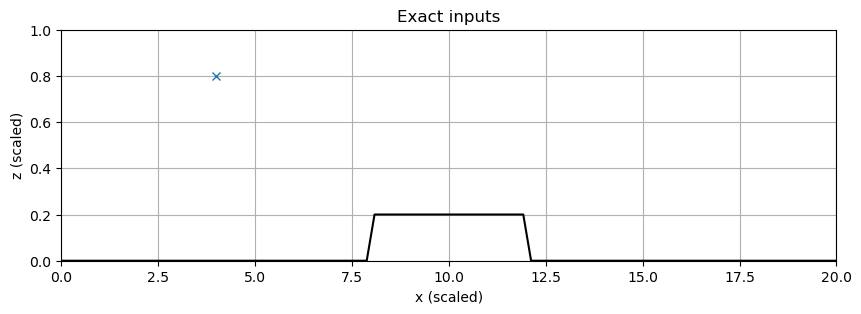

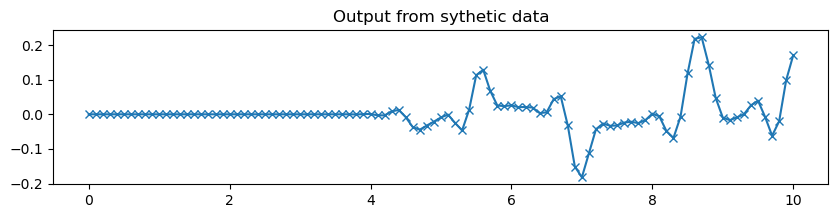

In [36]:
# plot "domain" (to improve)

# Note that the x coords of the sensor are given in scaled coordinates, not in DoFs.
# To plot them, need to find the closest 'dof' corresponding to the scaled coordinates 

# Plot captors location
H = 1.5
x_sensor = np.array(sensors)[:,0]
y_sensor = np.array(sensors)[:,1]

# Plot exact input location 
# figIn, axIn = plt.subplots(figsize=(24,4))
figIn, axIn = plt.subplots(figsize=(10, 3))
axIn.plot(x_sensor[0],y_sensor[0],'x')
axIn.plot(np.linspace(0,Lx,nx)*1, exact*0.2, color="k")
axIn.set_title("Exact inputs")
axIn.set_xlabel("x (scaled)")
axIn.set_ylabel("z (scaled)")
axIn.set_xlim(0,Lx)
axIn.set_ylim(0,1)
axIn.grid()


# Plot output from exact location
fig, ax = plt.subplots(1, figsize=(10,2), sharex=True)
t=np.linspace(0, TEnd, ny)
ax.set_title('Output from sythetic data')
ax.plot(t,d_true, 'x-')

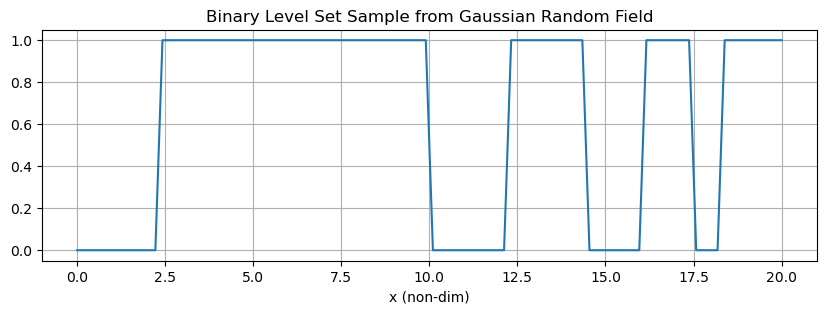

In [49]:
# Create level set of Gaussian random field
# TODO: how to scale / choose lenght_scale and decay_rate appropriately for a given domain size?
# GRF parameters
length_scale = 1
decay_rate = 10

# Level-set parameter
eps = 1e-6

def rbf_covariance(grid, length_scale, variance=1.0):
    dists = cdist(grid, grid, 'euclidean')
    return variance * np.exp(-0.5 * (dists / length_scale) ** 2)

def restriction(sampin):
    field_cut = sampin
    return (field_cut > eps).astype(int)

dx = Lx/nx
x = np.linspace(0, Lx, nx).reshape(-1, 1)
cov = rbf_covariance(x, length_scale)
cov += eps * np.eye(nx)
mean = np.zeros(nx)
my_prior = multivariate_normal(mean=mean, cov=cov)


### Example of a prior 
sample = my_prior.rvs()
sample = restriction(sample)

fig, ax = plt.subplots(figsize=(10, 3))
ax.grid()
ax.plot(x, sample)
ax.set_title("Binary Level Set Sample from Gaussian Random Field")
ax.set_xlabel("x (non-dim)")
plt.show()

[4.] [0.8]


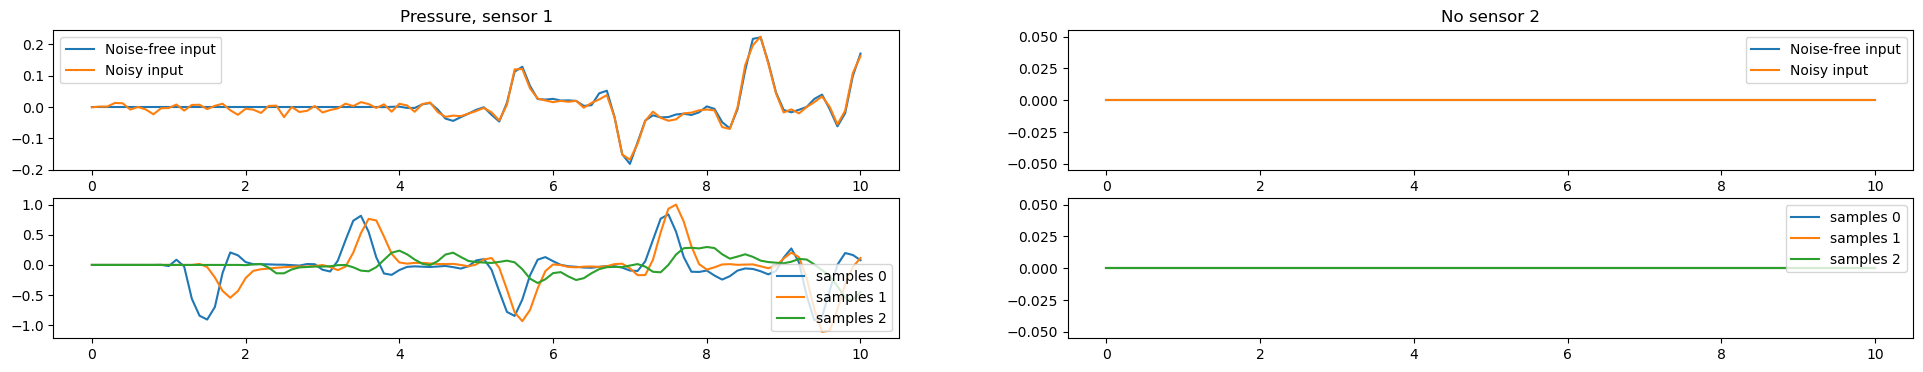

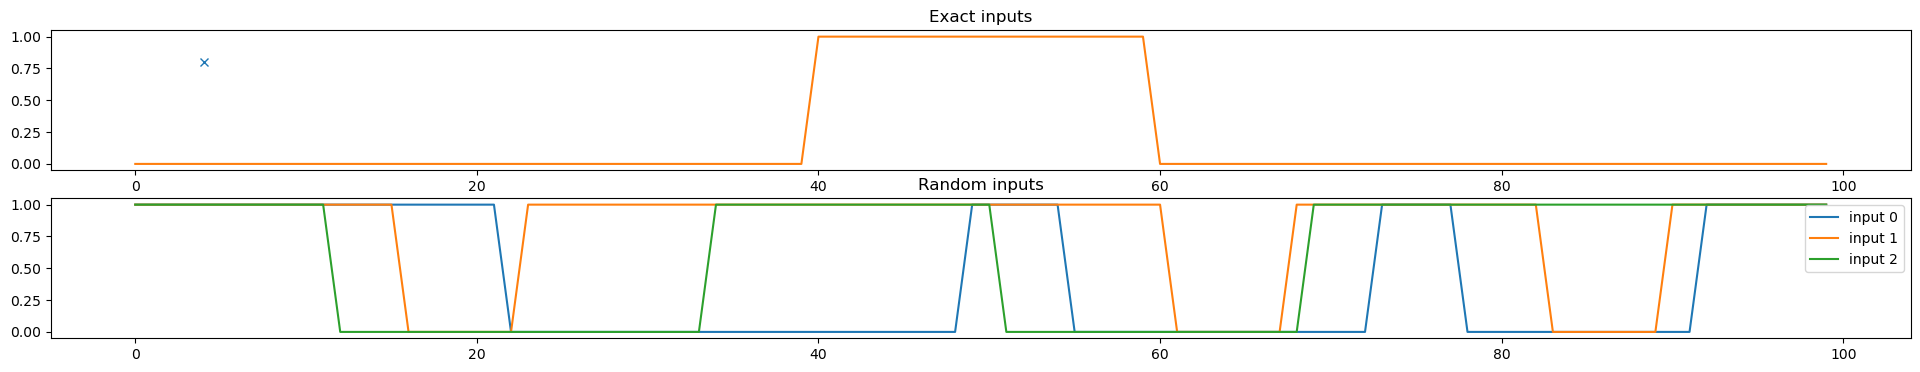

In [50]:
# plot several output and the exact (with/without noise) input/output
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(24,4))
figIn, axIn = plt.subplots(nrows=2, figsize=(24,4))

# exact (with/without noise) input/output 
xCapt = np.array(sensors)[:,0]
yCapt = np.array(sensors)[:,1]
print(xCapt, yCapt)

axIn[0].plot(xCapt,yCapt,'x')
axIn[0].plot(exact)
axIn[0].set_title("Exact inputs")

if(n_sensors==1):
     t = np.linspace(0,TEnd,ny)
     d_true1 = np.array(d_true)
     d_true2 = np.zeros_like(d_true)
     d1 = np.array(d)
     d2 = np.zeros_like(d)
     
if(n_sensors==2):
     t = np.linspace(0,TEnd,int(ny/2))
     d_true1 = np.array(d_true)[0:ny:2]
     d_true2 = np.array(d_true)[1:ny:2]
     d1 = np.array(d)[0:ny:2]
     d2 = np.array(d)[1:ny:2]
     
ax[0][0].set_title('Pressure, sensor 1')
ax[0][0].plot(t,d_true1, label='Noise-free input')
ax[0][0].plot(t,d1, label='Noisy input')
ax[0][0].legend()

ax[0][1].set_title('Pressure, sensor 2')
if(n_sensors==1):
     ax[0][1].set_title('No sensor 2')
ax[0][1].plot(t,d_true2, label='Noise-free input')
ax[0][1].plot(t,d2, label='Noisy input')
ax[0][1].legend()


# Plot several random samples
samples = []
inputs=[]
for x in range(3):
     log = my_prior.rvs()
     log = restriction(log)
     d_sample = my_model(log)

     if(n_sensors==1):
          d_sample1 = d_sample
          d_sample2 = np.zeros_like(d_sample)
     
     if(n_sensors==2):
          d_sample1 = np.array(d_sample)[0:ny:2]
          d_sample2 = np.array(d_sample)[1:ny:2]
     
     ax[1][0].plot(t, d_sample1, label=f'samples {x}')
     ax[1][1].plot(t, d_sample2, label=f'samples {x}')

     axIn[1].plot(range(len(log)), log, label=f'input {x}')
     samples.append(d_sample)
     inputs.append(log)

ax[1][0].legend()
ax[1][1].legend()
axIn[1].set_title("Random inputs")
axIn[1].legend()

plt.show()

## Set up log-likelihood

Test standard Gaussian log-likelihood:
$$\log ⁡L(x)=-0.5(x-y)^T\Sigma^{-1}(x−y)$$

with a Wasserstein-2-based log-likelihood as in Dunlop+Yang, 2021:
$$\log ⁡L(x)\propto -\lambda W_2(x,y),$$

where:
- x = model output
- y = ground truth
- λ = scale parameter (e.g. inverse covariance)

While $W_1$ is contained in scipy.stats it seems $W_2$ is not

In [51]:
class WassersteinLoglike:
    """
    Wasserstein-2 based log-likelihood
    """

    def __init__(self, data, lam=1.0):
        """
        Parameters
        ----------
        data : np.ndarray
            ground truth.
        lam : float
            Scaling factor (like inverse variance).
        """
        self.data = np.sort(data)
        self.lam = lam

    def loglike(self, x):
        """
        Compute the log-likelihood using squared W₂ distance.
        
        Parameters
        ----------
        x : np.ndarray
            Model output (same shape as data).
        
        Returns
        -------
        float
            Log-likelihood (unnormalized).
        """
        x_sorted = np.sort(x)
        return -self.lam * np.mean((x_sorted - self.data) ** 2)

    def grad_loglike(self, x):
        """
        Gradient of the W₂ log-likelihood.
        
        Returns
        -------
        np.ndarray
            Gradient of the log-likelihood.
        """
        n = len(x)
        sort_idx = np.argsort(x)
        x_sorted = x[sort_idx]
        y_sorted = self.data

        grad_sorted = -2 * self.lam * (x_sorted - y_sorted) / n

        grad = np.zeros_like(x)
        grad[sort_idx] = grad_sorted
        return grad
    
# Test for Gaussian log like
#sigma = 2.0
#cov_likelihood = sigma**2*np.eye(d_true.shape[0])
#my_loglike = tda.GaussianLogLike(d_true, cov_likelihood)

# Test for Wasserstain based log like
# TODO move implementation into tinyDA
my_loglike = WassersteinLoglike(d_true, 100.0)

In [52]:
print("true ", np.exp(my_loglike.loglike(d_true)))
print("true + small noise ", np.exp(my_loglike.loglike(d)))

for d_sample in samples:
    print(np.exp(my_loglike.loglike(d_sample)))

true  1.0
true + small noise  0.9955011916325784
0.0006431143808737236
0.00027236987146194537
0.32604017773906946


In [53]:
# initialise the Posterior
def levelset_model(parameters):
    levelset_params = restriction(parameters)
    return my_model(levelset_params)

my_posterior = tda.Posterior(my_prior, my_loglike, levelset_model)
#my_posterior = tda.Posterior(my_prior, my_loglike, my_model)

### Set up the proposal

In [54]:
# Custom Crank-Nicolson with cutoff and levelset
class CrankNicolson(tda.CrankNicolson):
    def __init__(self, scaling, adaptive):
        super().__init__(scaling=scaling, adaptive=adaptive)

    def make_proposal(self, link):
        # make a pCN proposal.
        self.scaling = min(self.scaling, 1.0 - 1e-3)
        return np.sqrt(
            1 - self.scaling**2
        ) * link.parameters + self.scaling * np.random.multivariate_normal(
            self._mean, self.C
        )

# preconditioned Crank-Nicolson
pcn_scaling = 0.15
pcn_adaptive = True
my_proposal = CrankNicolson(scaling=pcn_scaling, adaptive=pcn_adaptive)

# # random walk Metropolis
#rwmh_cov = np.eye(nx)
#rmwh_scaling = 0.1
#rwmh_adaptive = False
#my_proposal = tda.GaussianRandomWalk(C=rwmh_cov, scaling=rmwh_scaling, adaptive=rwmh_adaptive)

### Sample

In [55]:
# For testing purposes, iteration number is small for the given problem; Choose a larger number for real applications.
my_chains = tda.sample(my_posterior, my_proposal, iterations=3, n_chains=2, force_sequential=True)
# my_chains = tda.sample(my_posterior, my_proposal, iterations=6000, n_chains=2, force_sequential=True)

Sampling chain 1/2


Running chain, α = 0.33: 100%|██████████| 3/3 [06:47<00:00, 135.93s/it]


Sampling chain 2/2


Running chain, α = 0.67: 100%|██████████| 3/3 [06:53<00:00, 137.94s/it]


### Get some diagnostics

In [56]:
import arviz as az

In [ ]:
# convert the tinyDA chains to an ArViz InferenceData object.
burnin = 1000
#idata = tda.to_inference_data(my_chains, burnin=burnin)
#az.to_netcdf(idata, "results_wassersteinlog.nc") # to store
idata = az.from_netcdf("results_wassersteinlog.nc")# to load

In [ ]:
print(idata)
print(idata.sample_stats)

In [ ]:
# display posterior summary statistics.
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)
pd.set_option("display.max_rows", None)
info = az.summary(idata);
info

In [ ]:
# plot posterior kernel densities and traces.
az.plot_trace(idata)
plt.show()

In [ ]:
# extract the parameters from the chains.
subsampling_rate = 20
burnin = 2000
#parameters = [link.parameters for link in my_chains['chain_0'][burnin::subsampling_rate] + my_chains['chain_1'][burnin::subsampling_rate]]

# If loaded data need to do this, otherwise above is easier
idata_sub = idata.sel(draw=slice(burnin, None, subsampling_rate))
parameters = []
for i in range(idata_sub.posterior.draw.size):
    parameters = [
        np.array([idata_sub.posterior[var].values[0, i] for var in idata_sub.posterior.data_vars])
        for i in range(idata_sub.posterior.draw.size)
    ]

In [ ]:
n_samples = 100
ids = np.random.randint(0, len(parameters), n_samples)

# Evaluate model outputs and likelihoods
likelihoods = []
outputs = []

for i in ids:
    param = parameters[i]
    output = levelset_model(param)
    outputs.append(output)
    idata_sub = idata.sel(draw=slice(None, None, subsampling_rate))
    loglikes = idata_sub.sample_stats["likelihood"].values.flatten()
    #print("Likelihood ", loglikes[i])
    likelihoods.append(loglikes[i])

# Normalize likelihoods for colormap
likelihoods = np.array(likelihoods)
norm = colors.Normalize(vmin=np.min(likelihoods), vmax=np.max(likelihoods))
cmap = cm.viridis  # Or any matplotlib colormap
colors_list = [cmap(norm(l)) for l in likelihoods]

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))

d_true = np.array(d_true)
ax[0].plot(d_true[::2], 'k--', label="True output 1")
ax[1].plot(d_true[1::2], 'k--', label="True output 2")
for output in outputs:
    ax[0].plot(output[::2], alpha=0.03)
    ax[1].plot(output[1::2], alpha=0.03)
ax[0].legend()
ax[1].legend()
plt.tight_layout()
plt.show()

In [ ]:
n_samples = 100

# Evaluate model outputs and likelihoods
likelihoods = []
outputs = []

# Compare with draws from the prior
for ids in range(n_samples):
    log = my_prior.rvs()
    log = restriction(log)
    output = levelset_model(log)
    outputs.append(output)
    idata_sub = idata.sel(draw=slice(None, None, subsampling_rate))
    loglikes = idata_sub.sample_stats["likelihood"].values.flatten()
    likelihoods.append(loglikes[i])

# Normalize likelihoods for colormap
likelihoods = np.array(likelihoods)
norm = colors.Normalize(vmin=np.min(likelihoods), vmax=np.max(likelihoods))
cmap = cm.viridis  # Or any matplotlib colormap
colors_list = [cmap(norm(l)) for l in likelihoods]

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))

d_true = np.array(d_true)
ax[0].plot(d_true[::2], 'k--', label="True output 1")
ax[1].plot(d_true[1::2], 'k--', label="True output 2")
for output in outputs:
    ax[0].plot(output[::2], alpha=0.03)
    ax[1].plot(output[1::2], alpha=0.03)
ax[0].legend()
ax[1].legend()
plt.tight_layout()
plt.show()

In [ ]:
# Extract corresponding likelihoods
likelihoods = idata_sub.sample_stats["likelihood"].values[0, :]

# Sort parameter sets by decreasing likelihood
sorted_indices = np.argsort(-likelihoods)  # Negative for descending order
top_indices = sorted_indices[:5]

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))

d_true = np.array(d_true)
ax[0].plot(d_true[::2], 'k--', label="True output 1")
ax[1].plot(d_true[1::2], 'k--', label="True output 2")

for i in top_indices:
    param = parameters[i]
    output = np.array(levelset_model(param))
    loglike = likelihoods[i]
    ax[0].plot(output[::2], alpha=0.3, label=f"loglike: {loglike:.2f}")
    ax[1].plot(output[1::2], alpha=0.3, label=f"loglike: {loglike:.2f}")

ax[0].legend()
ax[1].legend()
plt.tight_layout()
plt.show()

In [ ]:
x=np.linspace(0,nx, nx)
t=np.linspace(0,25, int(ny/2))
d1 = np.array(d_true)[0:ny:2]
d2 = np.array(d_true)[1:ny:2]

output = levelset_model(info['mean'])
o1 = np.array(output)[0:ny:2]
o2 = np.array(output)[1:ny:2]

fig, ax = plt.subplots(figsize=(12,2))
ax.plot(t,d1, label='True output 1')
ax.plot(t,o1, label='mean output 1')
ax.legend()

fig, ax = plt.subplots(figsize=(12,2))
ax.plot(t,d2, label='True output 2')
ax.plot(t,o2, '--' ,label='mean output 2')
ax.legend()

In [ ]:
x = range(len(info))
plt.figure(figsize=(8, 6))
plt.plot(exact)
plt.title('Exact input')
eps = 5e-2
plt.plot(x, restriction(info['mean']), 'o')  # x = index, y = mean
#plt.plot(x, info['mean'], 'x')  # x = index, y = mean
#print(top_links[0])
#plt.plot(x, restriction(parameters[top_indices[0]]), 'x')  # x = index, y = mean
plt.plot([captors[0][0]*Nx/Lx,captors[1][0]*Nx/Lx],[0,0],'x')
plt.ylabel('mean')
plt.title('Posterior Means')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
az.plot_autocorr(idata);

In [ ]:
az.plot_posterior(idata);

In [ ]:
az.plot_rank(idata);

## Sequential Monte Carlo

Adjustments:
- replace manual logging with arvis inference structure (easier/faster saving in netcdf format, immediate access to plotting routines)
- replace prior class with scipy priors (compatibility with tinyDA code above)
- replace loglikelihood class with tinyDA style loglikelihood
- replace MCMC steps with tinyDA

In [ ]:
from os import sys, path, getcwd
sys.path.append(path.dirname(getcwd()))

import functools as ft

import warnings
import matplotlib.cbook
import scipy.stats as stats

from SMC import *

Start with the example provided before moving on to more complex model

In [ ]:
### M:  number of particles/samples for SMC
num_samples = 10

### var: uncertainty variance of measurements/modeling
std_noise = 0.05

### Title for saving the results
run = "acousticgravity"  # or any identifier you want
resultspath = f'RESULTS/SMC_M_{num_samples}_{run}'

In [ ]:
# Wrapper for scipy prior
class prior:
    def __init__(self, prior, d = 1):
        self.d = d # dimension of prior/parameter space, here 1
        self.RV = prior # this is specific to this prior

    def rvs(self, M):
        # Generate n samples. The resulting numpy array must be [1:d, 1:M]
        return np.array([self.RV.rvs(size=M) for i in range(self.d)])

    def logpdf(self, particle):
        # Compute logpdf at a point "particle"-
        return np.sum([self.RV.logpdf(particle[i]) for i in range(self.d)])

nx = 1 # 1D test case just to start!
length_scale = 5.0
eps = 1e-6
decay_rate = 10

x = np.linspace(0, nx - 1, nx).reshape(-1, 1)
def rbf_covariance(grid, length_scale, variance=1.0):
    dists = cdist(grid, grid, 'euclidean')
    return variance * np.exp(-0.5 * (dists / length_scale) ** 2)

cov = rbf_covariance(x, length_scale)
cov += eps * np.eye(nx)
mean = np.zeros(nx)
my_prior = prior(stats.multivariate_normal(mean=mean, cov=cov), d=1)

In [ ]:
### Set up forward model
def forward_model(x0):
    #Transform x0 to single location in input parameter vector (simplified testcase, to be replaced later)
    # True x0 is 70
    nx = umbridge_model.get_input_sizes(config)[0]
    xvec = np.zeros(nx)
    if 0 <= x0[0] - 10 < nx: xvec[int(x0[0]) - 10] = 1
    if 0 <= x0[0] + 10 < nx: xvec[int(x0[0]) + 10] = 1
    output = levelset_model(xvec)   
    return output

def potential(particle, data, std_noise = 0.05):
    fwd_vals = forward_model(particle)
    #return 1.*(np.linalg.norm(fwd_vals-data)**2/(2.*std_noise**2)) 
    return my_loglike.loglike(fwd_vals)

# Multiprocessing evaluation of previous potential 
def potential_mp(particles,data, std_noise = 0.05):
    pool = mp.Pool()
    potentials = pool.map(ft.partial(potential, data=data, std_noise=std_noise),particles.T)
    pool.close()
    return np.array(potentials)


In [ ]:
### SET UP SMC SAMPLER  
SMC_sampler = SMC(my_prior, lambda x: potential_mp(x, data = d_true, std_noise = std_noise), resultspath, d_true, num_samples)
SMC_sampler.smc_tempering() ### perform SMC algorithm